# Solar Power Forecasting Using Vector Auto Regression

1. Read labeled data from output.xlsx
2. Set forecast_days
3. Generate probabilistic labels
4. Run VAR

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
forecast_days = 12

In [3]:
xls = pd.ExcelFile("output.xlsx")

In [4]:
years = ["2012","2013","2014","2015","2016","2017","2018","2019","2020"]

In [5]:
df_obj = dict()
for i in years:
    df_obj[i] = pd.read_excel(xls, i)
    df_obj[i] = df_obj[i].drop(["Unnamed: 0"],axis=True)

## Forecasting start

In [6]:
df = df_obj['2015']
# df = df.append(df_obj['2016'])
for i in range(2016,2019):
    df = df.append(df_obj[str(i)])
    
df1 = df.drop([ "Total Generation (KWH)",
                    "Aggregate Meter Reading (KWH)", 
                    "Difference", "SEEDs data (KWH)",  
                    "PR (%)", "Any Issues/Problems Observed", "WO#", "NO-OFF-CLEAN MODULES"], axis=1)

In [7]:
df1

,Date,1104500527,1104500529,1.104501e+09,7802195.0,2100570073/ 2100567820/ 2100567898,Insolation,Grid Failure,Inverter,Module Cleaning,Rainy day,No Module Cleaning,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy,Module Cleaning by rains
0,2015-01-01,542.0,560.0,509.0,529.0,22.50,2.780,0,0,0,0,0,0,1,0,0,0,0,0
1,2015-01-02,792.0,831.0,842.0,821.0,36.93,4.150,1,0,0,0,0,0,0,0,0,0,0,0
2,2006-01-03,933.0,978.0,995.0,953.0,49.96,5.303,1,0,0,0,0,0,0,0,0,0,0,0
3,2015-01-04,1046.0,1102.0,1114.0,1071.0,61.29,NaN,1,0,0,0,0,0,0,0,0,0,0,0
4,2015-01-05,893.0,939.0,944.0,902.0,41.55,4.800,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2018-12-27,853.0,1073.0,1039.0,1124.0,40.29,5.747,1,0,1,0,0,0,0,0,0,0,0,0
361,2018-12-28,904.0,1114.0,1063.0,1144.0,41.50,5.689,0,0,1,0,0,0,0,0,0,0,0,0
362,2018-12-29,809.0,978.0,938.0,973.0,34.03,5.834,1,0,1,0,0,0,0,0,0,0,0,0
363,2018-12-30,814.0,1074.0,1018.0,1119.0,38.88,5.584,0,1,0,0,0,0,0,0,0,0,0,0


In [8]:
df1['Date'] = pd.to_datetime(df1['Date'])

In [9]:
df1 = df1.set_index('Date')

In [10]:
# for i in df1.columns[6:]:
#     print(i)
#     temp = df1[i].value_counts().to_dict()
#     print(temp)
#     if 1.0 in temp.keys():
#         df1[str(i)][df1[str(i)] == 1.0] = (temp[1.0]/100)**2

In [11]:
df1.head()

,1104500527,1104500529,1.104501e+09,7802195.0,2100570073/ 2100567820/ 2100567898,Insolation,Grid Failure,Inverter,Module Cleaning,Rainy day,No Module Cleaning,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy,Module Cleaning by rains
Date,,,,,,,,,,,,,,,,,,
2015-01-01,542.0,560.0,509.0,529.0,22.50,2.780,0,0,0,0,0,0,1,0,0,0,0,0
2015-01-02,792.0,831.0,842.0,821.0,36.93,4.150,1,0,0,0,0,0,0,0,0,0,0,0
2006-01-03,933.0,978.0,995.0,953.0,49.96,5.303,1,0,0,0,0,0,0,0,0,0,0,0
2015-01-04,1046.0,1102.0,1114.0,1071.0,61.29,NaN,1,0,0,0,0,0,0,0,0,0,0,0
2015-01-05,893.0,939.0,944.0,902.0,41.55,4.800,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# df1['Total Generation (KWH)'] = pd.to_numeric(df1['Total Generation (KWH)'])
# df1['Total Generation (KWH)'].dtype

In [13]:
corr_df = df1.corr()
# corr_df[corr_df < 0] = 0
corr_df

,1104500527,1104500529,1.104501e+09,7802195.0,2100570073/ 2100567820/ 2100567898,Insolation,Grid Failure,Inverter,Module Cleaning,Rainy day,No Module Cleaning,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy,Module Cleaning by rains
1104500527,1.000000,0.949781,0.940975,0.696857,0.835213,-0.054230,-0.095854,-0.185670,0.362456,-0.227665,-0.037803,-0.022980,0.069202,0.029562,0.015350,0.023966,-0.510429,NaN
1104500529,0.949781,1.000000,0.955294,0.742835,0.800576,-0.055613,-0.090371,-0.180790,0.365522,-0.241483,0.004120,-0.002590,0.057728,0.016962,0.001564,0.014308,-0.510174,NaN
1.104501e+09,0.940975,0.955294,1.000000,0.738457,0.804742,-0.057051,-0.095585,-0.195549,0.369302,-0.260689,-0.007619,0.001131,0.058406,0.017425,0.007178,0.015761,-0.504173,NaN
7802195.0,0.696857,0.742835,0.738457,1.000000,0.624003,-0.032858,-0.125387,-0.515984,0.373472,-0.400530,0.062336,-0.014221,0.049860,0.016097,0.007055,0.012259,-0.513005,NaN
2100570073/ 2100567820/ 2100567898,0.835213,0.800576,0.804742,0.624003,1.000000,-0.040992,-0.099615,-0.193163,0.289832,-0.208721,-0.037132,0.006008,0.083545,0.056199,0.044048,0.054748,-0.468281,NaN
Insolation,-0.054230,-0.055613,-0.057051,-0.032858,-0.040992,1.000000,0.038118,0.081044,-0.016248,-0.019640,-0.006855,-0.001286,-0.004468,0.000007,NaN,-0.000268,-0.046018,NaN
Grid Failure,-0.095854,-0.090371,-0.095585,-0.125387,-0.099615,0.038118,1.000000,0.060894,0.023704,0.005612,-0.095742,-0.008704,-0.007101,0.034079,-0.034836,-0.020099,-0.031126,NaN
Inverter,-0.185670,-0.180790,-0.195549,-0.515984,-0.193163,0.081044,0.060894,1.000000,-0.388241,0.420938,-0.088625,0.039255,-0.067396,-0.009274,-0.016075,-0.009274,0.233595,NaN
Module Cleaning,0.362456,0.365522,0.369302,0.373472,0.289832,-0.016248,0.023704,-0.388241,1.000000,-0.193057,-0.273995,0.014713,0.008827,0.023888,0.011037,-0.028673,-0.469456,NaN
Rainy day,-0.227665,-0.241483,-0.260689,-0.400530,-0.208721,-0.019640,0.005612,0.420938,-0.193057,1.000000,-0.044070,0.016624,-0.011694,-0.004612,-0.007993,-0.004612,0.309879,NaN


In [14]:
# total_0 = 0
# total_1 = 0
# for i in df1.columns[1:]:
#     value_c = df1[i].value_counts()
#     print(df1[i].value_counts())
#     total_0 += value_c[]

In [15]:
df1 = df1.drop(["Cable and Fuse maintenance","No Module Cleaning","Rainy day","Transformer replacement and maintenance","Plant Shutdown","Internet","Battery","Module Cleaning by rains"], axis=1)
df1

,1104500527,1104500529,1.104501e+09,7802195.0,2100570073/ 2100567820/ 2100567898,Insolation,Grid Failure,Inverter,Module Cleaning,Cloudy
Date,,,,,,,,,,
2015-01-01,542.0,560.0,509.0,529.0,22.50,2.780,0,0,0,0
2015-01-02,792.0,831.0,842.0,821.0,36.93,4.150,1,0,0,0
2006-01-03,933.0,978.0,995.0,953.0,49.96,5.303,1,0,0,0
2015-01-04,1046.0,1102.0,1114.0,1071.0,61.29,NaN,1,0,0,0
2015-01-05,893.0,939.0,944.0,902.0,41.55,4.800,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2018-12-27,853.0,1073.0,1039.0,1124.0,40.29,5.747,1,0,1,0
2018-12-28,904.0,1114.0,1063.0,1144.0,41.50,5.689,0,0,1,0
2018-12-29,809.0,978.0,938.0,973.0,34.03,5.834,1,0,1,0


In [16]:
df1['Insolation'] = df1['Insolation'].fillna(df1['Insolation'].mean())

In [17]:
df1 = df1.fillna(0)

In [18]:
exog_array = df1.drop(['1104500527','1104500529','1.104501e+09','7802195.0','2100570073/ 2100567820/ 2100567898'],axis=1).to_numpy(dtype=float)


In [19]:
endog_array = df1.to_numpy(dtype=int)

In [20]:
temp_endog_array = df1.drop(['Insolation','Grid Failure','Inverter','Module Cleaning','Cloudy'], axis=1).to_numpy(dtype=float)

In [21]:
temp_endog_array.shape

(1461, 5)

In [22]:
# temp_endog_array = temp_endog_array.reshape(temp_endog_array.shape[0],1)

In [23]:
temp_endog_array.shape

(1461, 5)

In [24]:
exog_array.shape

(1461, 5)

In [25]:
exog_array

array([[2.78 , 0.   , 0.   , 0.   , 0.   ],
       [4.15 , 1.   , 0.   , 0.   , 0.   ],
       [5.303, 1.   , 0.   , 0.   , 0.   ],
       ...,
       [5.834, 1.   , 0.   , 1.   , 0.   ],
       [5.584, 0.   , 1.   , 0.   , 0.   ],
       [5.635, 1.   , 0.   , 1.   , 0.   ]])

In [26]:
mod = sm.tsa.VARMAX(temp_endog_array, trend='n', 
                    exog=exog_array, order=(2,0,0,0,0),)


## Casuality test

In [27]:
df1

,1104500527,1104500529,1.104501e+09,7802195.0,2100570073/ 2100567820/ 2100567898,Insolation,Grid Failure,Inverter,Module Cleaning,Cloudy
Date,,,,,,,,,,
2015-01-01,542.0,560.0,509.0,529.0,22.50,2.780000,0,0,0,0
2015-01-02,792.0,831.0,842.0,821.0,36.93,4.150000,1,0,0,0
2006-01-03,933.0,978.0,995.0,953.0,49.96,5.303000,1,0,0,0
2015-01-04,1046.0,1102.0,1114.0,1071.0,61.29,6.372375,1,0,0,0
2015-01-05,893.0,939.0,944.0,902.0,41.55,4.800000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2018-12-27,853.0,1073.0,1039.0,1124.0,40.29,5.747000,1,0,1,0
2018-12-28,904.0,1114.0,1063.0,1144.0,41.50,5.689000,0,0,1,0
2018-12-29,809.0,978.0,938.0,973.0,34.03,5.834000,1,0,1,0


In [28]:
maxlag=8
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df1, variables = df1.columns)

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/p

,1104500527_x,1104500529_x,1.104501e+09_x,7802195.0_x,2100570073/ 2100567820/ 2100567898_x,Insolation_x,Grid Failure_x,Inverter_x,Module Cleaning_x,Cloudy_x
1104500527_y,1.0000,0.0000,0.0000,0.0000,0.0000,0.0026,0.0000,0.1921,0.0438,0.0000
1104500529_y,0.1115,1.0000,0.0002,0.0335,0.0000,0.0056,0.0002,0.1037,0.0002,0.0000
1.104501e+09_y,0.1519,0.0038,1.0000,0.3718,0.0000,0.0049,0.0001,0.1957,0.0002,0.0000
7802195.0_y,0.0000,0.0000,0.0000,1.0000,0.0001,0.0022,0.0003,0.0000,0.3303,0.0417
2100570073/ 2100567820/ 2100567898_y,0.0000,0.0000,0.0000,0.0072,1.0000,0.1902,0.0002,0.1885,0.2632,0.0010
Insolation_y,0.3465,0.3763,0.3941,0.2185,0.2823,1.0000,0.2606,0.5497,0.1077,0.0000
Grid Failure_y,0.5159,0.5599,0.5859,0.0071,0.1729,0.2454,1.0000,0.0194,0.1266,0.0478
Inverter_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0133,0.0124,1.0000,0.0029,0.0000
Module Cleaning_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.1714,0.0179,0.1302,1.0000,0.0000
Cloudy_y,0.0030,0.0003,0.0003,0.0009,0.0000,0.1934,0.4715,0.0210,0.0299,1.0000


In [29]:
adfuller_result = adfuller(df1['2100570073/ 2100567820/ 2100567898'])

In [30]:
adfuller_result[1]

0.015537153266006395

In [31]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [32]:
# varmax_result = mod.fit(disp=False)

In [33]:
# varmax_result.summary()

In [34]:
# varmax_result.

In [35]:
# varmax_result.get_forecast(step=forecast_days)

In [36]:
# varmax_pred = varmax_result.get_prediction(start=len(temp_endog_array), end=len(temp_endog_array)+forecast_days-1)

## VAR

In [37]:
var_model = VAR(endog_array)

In [38]:
temp_endog_array.shape

(1461, 5)

In [39]:
var_model.select_order(48).summary()

,AIC,BIC,FPE,HQIC
0,44.73,44.77,2.672e+19,44.75
1,36.63,37.04*,8.129e+15,36.79
2,36.35,37.13,6.143e+15,36.65*
3,36.29,37.44,5.766e+15,36.72
4,36.33,37.85,5.991e+15,36.90
5,36.34,38.24,6.064e+15,37.05
6,36.38,38.65,6.327e+15,37.23
7,36.22,38.86,5.386e+15,37.21
8,36.19*,39.20,5.214e+15*,37.31
9,36.25,39.63,5.546e+15,37.51


In [40]:
results = var_model.fit(8, trend='c', ic='aic')

In [41]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Mar, 2022
Time:                     17:08:33
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    39.1789
Nobs:                     1453.00    HQIC:                   37.3333
Log likelihood:          -46131.7    FPE:                5.45805e+15
AIC:                      36.2347    Det(Omega_mle):     3.17278e+15
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const        197.530823        32.199837            6.135           0.000
L1.y1          0.925850         0.063448           14.592           0.000
L1.y2         -0.080809         0.074323           -1.087           0.277
L1.y3         -0.

In [42]:
lag = results.k_ar

In [43]:
forecast_results = results.forecast(df1.values[-lag:],steps=forecast_days)

In [44]:
forecast_results

array([[8.20523618e+02, 9.53839295e+02, 8.44407344e+02, 1.08507043e+03,
        3.58583770e+01, 1.73043107e+00, 1.47252989e-01, 2.49827199e-01,
        7.57512955e-01, 6.48549755e-02],
       [8.85880081e+02, 1.03703415e+03, 9.78614664e+02, 1.09931425e+03,
        3.77185625e+01, 1.17990656e+01, 2.89306518e-01, 1.56087179e-01,
        7.41516552e-01, 2.22625741e-02],
       [9.06865127e+02, 1.05873431e+03, 9.99938649e+02, 1.08888108e+03,
        3.91263540e+01, 7.30666681e+00, 3.95541557e-01, 1.05640808e-01,
        8.22082796e-01, 3.57963592e-02],
       [9.07607529e+02, 1.08081902e+03, 1.02194596e+03, 1.13366166e+03,
        3.87316798e+01, 6.79824908e+00, 4.02138706e-01, 1.41447486e-01,
        6.77887619e-01, 5.44211995e-02],
       [8.83157506e+02, 1.04857757e+03, 9.91101895e+02, 1.11617745e+03,
        3.74449317e+01, 5.63271397e+00, 4.56351587e-01, 1.00426983e-01,
        8.37161429e-01, 7.73380020e-02],
       [9.23686456e+02, 1.10512839e+03, 1.06532585e+03, 1.11997669e+03,
   

## Results

In [45]:
df1.head()

,1104500527,1104500529,1.104501e+09,7802195.0,2100570073/ 2100567820/ 2100567898,Insolation,Grid Failure,Inverter,Module Cleaning,Cloudy
Date,,,,,,,,,,
2015-01-01,542.0,560.0,509.0,529.0,22.50,2.780000,0,0,0,0
2015-01-02,792.0,831.0,842.0,821.0,36.93,4.150000,1,0,0,0
2006-01-03,933.0,978.0,995.0,953.0,49.96,5.303000,1,0,0,0
2015-01-04,1046.0,1102.0,1114.0,1071.0,61.29,6.372375,1,0,0,0
2015-01-05,893.0,939.0,944.0,902.0,41.55,4.800000,0,0,0,0


In [46]:
forecast_power1 = []
forecast_power2 = []
forecast_power3 = []
forecast_power4 = []
forecast_power5 = []
insolation_pred = []
grid_pred = []
inverter_pred = []
module_pred = []
cloudy_pred = []
for i in forecast_results:
    forecast_power1.append(i[0])
    forecast_power2.append(i[1])
    forecast_power3.append(i[2])
    forecast_power4.append(i[3])
    forecast_power5.append(i[4])
    insolation_pred.append(i[5])
    grid_pred.append(i[6])
    inverter_pred.append(i[7])
    module_pred.append(i[8])
    cloudy_pred.append(i[9])

In [62]:
insolation_pred

[1.7304310693956793,
 11.799065633304465,
 7.3066668123661955,
 6.7982490838231,
 5.632713973193756,
 7.351992503134317,
 7.229586988629815,
 5.883903872933782,
 8.393729471110925,
 5.950080645615648,
 6.5152189854885005,
 7.108256263792703]

In [64]:
original_insolation = df_obj['2019']['Insolation'][:forecast_days]

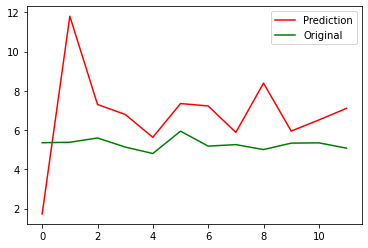

In [67]:
plt.plot(insolation_pred, c='r', label="Prediction")
plt.plot(original_insolation, c='g', label="Original")
plt.legend()
plt.show()

In [47]:
original_1 = df_obj['2019']['1104500527'][:forecast_days]
original_2 = df_obj['2019']['1104500529'][:forecast_days]
original_3 = df_obj['2019']['1.104501e+09'][:forecast_days]
original_4 = df_obj['2019']['7802195.0'][:forecast_days]
original_5 = df_obj['2019']['2100570073/ 2100567820/ 2100567898'][:forecast_days]
original_power = pd.DataFrame([original_1,original_2,original_3,original_4,original_5])
original_power = original_power.T
original_power.head()

,1104500527,1104500529,1.104501e+09,7802195.0,2100570073/ 2100567820/ 2100567898
0,814.0,990.0,947.0,1024.0,37.94
1,809.0,1023.0,988.0,1063.0,37.74
2,859.0,1046.0,1049.0,1119.0,40.45
3,803.0,1006.0,978.0,1048.0,38.59
4,775.0,944.0,907.0,943.0,34.61


In [48]:
diff_variable = pd.DataFrame({"Insolation":insolation_pred[:forecast_days],
                           "Grid_pred":grid_pred[:forecast_days],
                          "Module_pred":module_pred[:forecast_days],"Cloudy_pred":cloudy_pred[:forecast_days],
                          "Inverter_pred":inverter_pred[:forecast_days]})

pred_power = pd.DataFrame({'1104500527':forecast_power1, 
                           '1104500529':forecast_power2, 
                           '1.104501e+09':forecast_power3, 
                           '7802195.0':forecast_power4, 
                           '2100570073/ 2100567820/ 2100567898':forecast_power5}
                          )
# diff_power['Difference'] = diff_power['Prediction'] - diff_power['Original']
pred_power

,1104500527,1104500529,1.104501e+09,7802195.0,2100570073/ 2100567820/ 2100567898
0,820.523618,953.839295,844.407344,1085.070433,35.858377
1,885.880081,1037.034155,978.614664,1099.314251,37.718563
2,906.865127,1058.734310,999.938649,1088.881080,39.126354
3,907.607529,1080.819025,1021.945961,1133.661664,38.731680
4,883.157506,1048.577566,991.101895,1116.177455,37.444932
5,923.686456,1105.128390,1065.325848,1119.976692,39.271909
6,928.353010,1079.459934,1053.779457,1090.689828,39.554344
7,918.984016,1073.881465,1063.671126,1095.889537,38.716349
8,916.915787,1069.825285,1040.106815,1083.988715,39.008530
9,926.535779,1078.997692,1060.712216,1082.376736,39.142055


## New Result plotting

In [49]:
mean_squared_error(original_power, pred_power)**(1/2)

63.655978826145216

In [50]:
import matplotlib.pyplot as plt

In [51]:
original_power.columns

Index(['1104500527', '1104500529', '1.104501e+09', '7802195.0',
       '2100570073/ 2100567820/ 2100567898'],
      dtype='object')

In [52]:
original_power.columns

Index(['1104500527', '1104500529', '1.104501e+09', '7802195.0',
       '2100570073/ 2100567820/ 2100567898'],
      dtype='object')

In [53]:
original_power['Total'] = original_power['1104500527'] + original_power['1104500529'] + original_power['1.104501e+09'] + original_power['7802195.0'] + original_power['2100570073/ 2100567820/ 2100567898']
pred_power['Total'] = pred_power['1104500527'] + pred_power['1104500529'] + pred_power['1.104501e+09'] + pred_power['7802195.0'] + pred_power['2100570073/ 2100567820/ 2100567898'] 
final_power_diff = pd.DataFrame({
    "Prediction" : pred_power['Total'],
    "Original" : original_power['Total']                           
})
final_power_diff

,Prediction,Original
0,3739.699067,3812.94
1,4038.561713,3920.74
2,4093.545520,4113.45
3,4182.765859,3873.59
4,4076.459354,3603.61
5,4253.389296,4401.37
6,4191.836572,3852.56
7,4191.142492,3913.55
8,4149.845131,3731.08
9,4187.764479,4058.75


<AxesSubplot:>

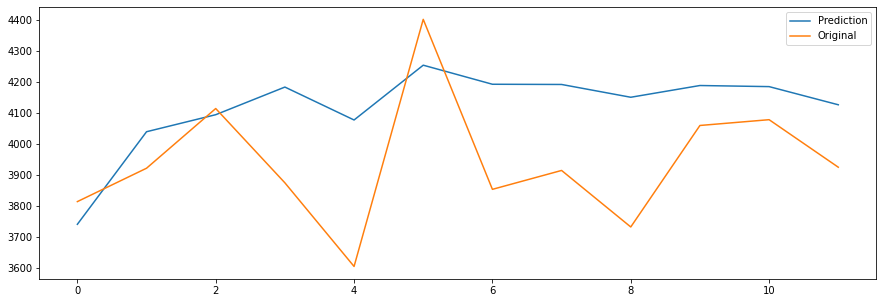

In [54]:
final_power_diff.plot(y=['Prediction','Original'],figsize=(15,5))

In [55]:
mean_squared_error(final_power_diff['Original'], final_power_diff['Prediction'])**(1/2)

257.7038544120263

In [61]:
np.sqrt(np.mean(np.square(((original_power - pred_power) / original_power)), axis=0))*100


1104500527                            9.806893
1104500529                            6.328282
1.104501e+09                          7.078194
7802195.0                             7.439636
2100570073/ 2100567820/ 2100567898    3.788031
Total                                 6.815026
dtype: float64

In [ ]:
np.sqrt(np.mean(np.square(((final_power_diff['Original'] - final_power_diff['Prediction']) / final_power_diff['Original'])), axis=0))*100


In [57]:
from sklearn.metrics import mean_absolute_percentage_error

In [58]:
mean_absolute_percentage_error(final_power_diff['Original'], final_power_diff['Prediction'])*100

5.661119877445545

In [59]:
mean_absolute_error(final_power_diff['Prediction'], final_power_diff['Original'])

217.83291254257085

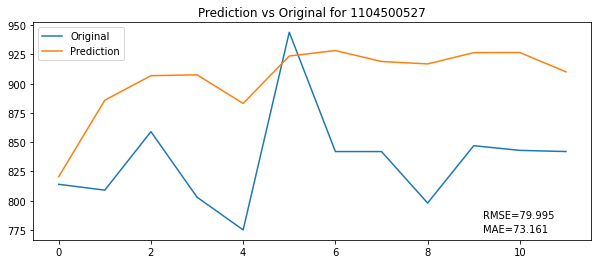

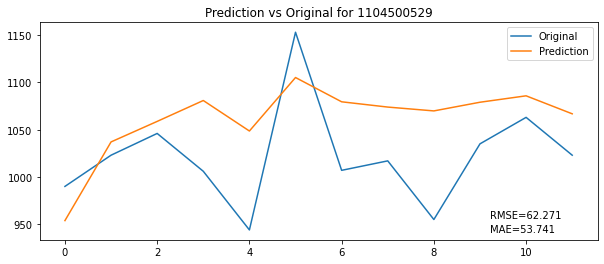

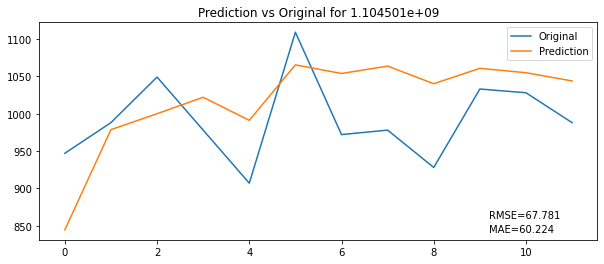

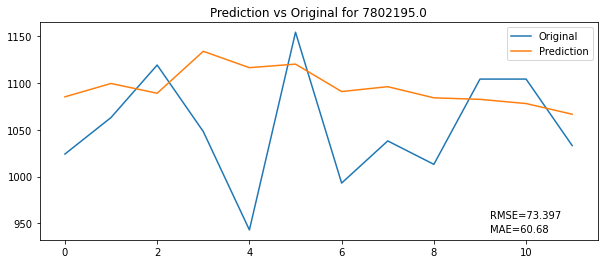

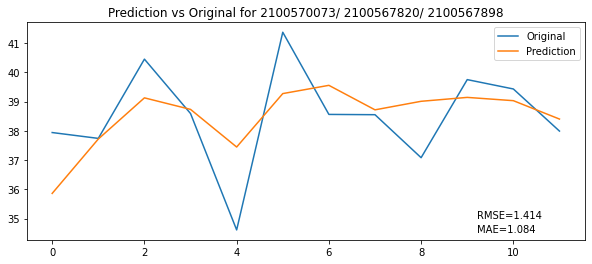

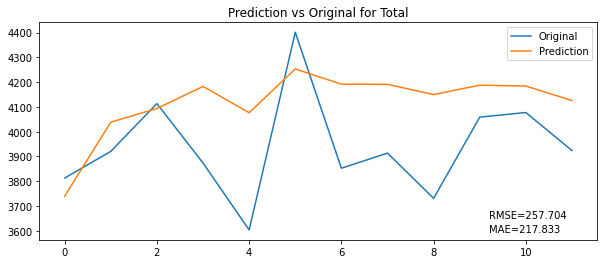

In [60]:
for i in original_power.columns:
    fig = plt.figure(figsize=(10,4)) 
    plt.plot(original_power[i], label='Original')
    plt.plot(pred_power[i], label="Prediction")
    plt.title("Prediction vs Original for "+i)
    rmse = mean_squared_error(original_power[i], pred_power[i])**(1/2)
    mae = mean_absolute_error(original_power[i], pred_power[i])
    plt.figtext(.75, .2, "RMSE="+str(round(rmse,3)))
    plt.figtext(.75, .15, "MAE="+str(round(mae,3)))
    plt.legend()
    plt.show()

## Plot results

In [56]:
# diff_power.plot(y=['Prediction','Original'],figsize=(15,5))

In [57]:
# mean_squared_error(power_16[:forecast_days],forecast_power)**(1/2)

In [58]:
# mean_absolute_error(power_16[:forecast_days],forecast_power)

In [59]:
# r2_score()